# **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas)

**Created by:** Vinícius Albano ([@vinialbano](https://github.com/vinialbano)) - CP3013677

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

**Custom CSS Styles**

In [3]:
%%html
<style>
.dashed-box {
    border: 1px dashed black !important;
#    font-size: var(--jp-content-font-size1) !important;
}

.dashed-box table {

}

.dashed-box tr {
    background-color: white !important;
}
        
.alt-tab {
    background-color: black;
    color: #ffc351;
    padding: 4px;
    font-size: 1em;
    font-weight: bold;
    font-family: monospace;
}
// add your CSS styling here
</style>

<span style='font-size: 2.5em'><b>São Paulo Real Estate 🏡</b></span><br/>
<span style='font-size: 1.5em'>Predict the sale/rent price of apartments in the city of São Paulo, Brazil.</span>

<span style="background-color: #ffc351; padding: 4px; font-size: 1em;"><b>Sprint #3</b></span>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Bandeira_da_cidade_de_S%C3%A3o_Paulo.svg/320px-Bandeira_da_cidade_de_S%C3%A3o_Paulo.svg.png">

---



## Before starting this notebook

This jupyter notebook is designed for **experimental and learning purposes.**
Although it is (relatively) well organized, it aims at solving the _target problem_ by evaluating (and documenting) _different solutions_ for some steps of the **machine learning pipeline** - see the ***[Machine Learning Project Checklist by xavecoding](https://github.com/xavecoding/IFSP-CMP-D2APR-2021.2/blob/main/cheat-sheets/machine-learning-project-checklist_by_xavecoding.pdf).***
I tried to make this notebook as literally a _notebook_. Thus, it contains notes, drafts, comments, etc.

For learning purposes, some parts of the notebook may be _overcommented._ Moreover, to simulate a real development scenarion, we will divide our solution and experiments into "**sprints**" in which each sprint has some goals (e.g., perform _feature selection_, train more ML models, ...).
The **sprint goal** wil be stated at the beginning of the notebook.

A ***final notebook*** (or any other kind of presentation) that complies and summarizes all sprint – the target problem, solutions, and findings – should be created later.

**Conventions**

<ul>
    <li>💡 indicates a tip. </li>
    <li> ⚠️ indicates a warning message. </li>
    <li><span class='alt-tab'>alt tab</span> indicates and an extra content (<i>e.g.</i>, slides) to explain a given concept.</li>
</ul>

---

## 🎯 Sprint Goals

- Frame the problem
- Get the data
- Data cleaning
- Simple EDA to gain insights
- Initial data preprocessing
- Train a (single) ML algorithm with all features and default hyperparameters

---

## 0. Imports and default settings for plotting

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## 🛠️ 5. Prepare the Data (Preprocessing)

In [5]:
# load the cleaned training set
df_train = pd.read_csv('./datasets/sao-paulo-properties_train_sprint-1.csv')

### 5.2. Separating the independent variables (features) and the dependent variable (target outcome)

In [6]:
df_train.columns

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District',
       'Negotiation Type', 'Latitude', 'Longitude'],
      dtype='object')

In [7]:
# store the target outcome into a numpy array
y_train = df_train['Price']

In [8]:
y_train

0          6000
1          1500
2        400000
3        785000
4          1700
          ...  
10651    275000
10652      2600
10653      2150
10654       900
10655      3500
Name: Price, Length: 10656, dtype: int64

In [9]:
# overwrite the dataframe with only the features  
df_train = df_train.drop(columns=['Price'])

### 5.3. Filling in missing values

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupMissingOrOutOfRangeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target, missing_val, upper_bound=np.inf, lower_bound=-np.inf, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(missing_val) == int or type(missing_val) == float, 'missing_val should be a number'
        assert type(upper_bound) == int or type(upper_bound) == float, 'upper_bound should be a number'
        assert type(lower_bound) == int or type(lower_bound) == float, 'lower_bound should be a number'
        assert type(target) == str, 'target should be a string'
        
        super().__init__()
        
        self.group_cols = group_cols
        self.target = target
        self.missing_val = missing_val
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X.loc[:, self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            attribute = X.loc[ind, self.target]
            mask = ((attribute == self.missing_val) | (attribute > self.upper_bound) | (attribute < self.lower_bound))
            X.loc[ind, self.target] = X.loc[ind, self.target].mask(mask, row[self.target])
        
        return X


In [11]:
condo_imputer = GroupMissingOrOutOfRangeImputer(group_cols=['District'], 
                   target='Condo',
                   missing_val=0,                   
                   metric='median')

condo_imputer.fit_transform(df_train)

# latitude_imputer = GroupMissingOrOutOfRangeImputer(group_cols=['District'], 
#                    target='Latitude',
#                    missing_val=0,
#                    upper_bound=-23.36,
#                    lower_bound=-24.00,
#                    metric='median')


# df_train = pd.DataFrame(latitude_imputer.fit_transform(df_train), 
#                       columns=df_train.columns)

# longitude_imputer = GroupMissingOrOutOfRangeImputer(group_cols=['District'], 
#                    target='Longitude',
#                    missing_val=0,
#                    upper_bound=-46.36,
#                    lower_bound=-46.84,
#                    metric='median')


# df_train = pd.DataFrame(longitude_imputer.fit_transform(df_train), 
#                       columns=df_train.columns)



# df_train.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Latitude,Longitude
0,2200.0,165,3,2,1,2,True,False,True,False,Alto de Pinheiros,rent,-23.541829,-46.718899
1,915.0,86,3,2,1,1,True,True,True,False,Vila Matilde,rent,-23.525410,-46.525949
2,560.0,50,2,2,1,1,True,False,True,False,Guaianazes,sale,-23.493276,-46.617289
3,550.0,67,2,2,1,1,False,False,True,False,Brooklin,sale,-23.618385,-46.684776
4,890.0,47,1,1,0,1,False,False,False,False,Santa Cecília,rent,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,500.0,51,2,2,1,1,False,False,False,False,Vila Matilde,sale,-23.533037,-46.529253
10652,1250.0,136,3,2,1,3,False,False,False,False,Freguesia do Ó,rent,-23.497544,-46.695865
10653,500.0,75,3,2,1,2,True,False,True,False,Vila Matilde,rent,-23.537197,-46.534562
10654,150.0,44,2,2,1,1,False,False,False,False,José Bonifácio,rent,-23.551798,-46.444855


### 5.4. Adding new features

Our transformer will create new features based on the current ones:

- `District`
- `Condo`
- `Size`
- `Rooms`
- `Toilets`
- `Suites`
- `Parking`

In [12]:
class ApartmentsNumericalFeatEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        pass
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        X = X.copy()
        
        # creating the new features
        X['Parkings per Room'] = X['Parking'] / X['Rooms']
        X['Parkings per Size'] = X['Parking'] / X['Size']
        X['Parkings per Condo'] = X['Parking'] / X['Condo']
        X['Parkings per Toilet'] = X['Parking'] / X['Toilets']
        X['Condo per Room'] = X['Condo'] / X['Rooms']
        X['Condo per Size'] = X['Condo'] / X['Size']
        X['Condo per Toilet'] = X['Condo'] / X['Toilets']
        X['Size per Room'] = X['Size'] / X['Rooms']
        X['Size per Condo'] = X['Size'] / X['Condo']
        X['Size per Toilet'] = X['Size'] / X['Toilets']
        X['Suites per Room'] = X['Suites'] / X['Rooms']
        X['Suites per Condo'] = X['Suites'] / X['Condo']
        X['Suites per Size'] = X['Suites'] / X['Size']
        X['Suites per Toilet'] = X['Suites'] / X['Toilets']
        X['Toilets per Room'] = X['Toilets'] / X['Rooms']
        X['Toilets per Condo'] = X['Toilets'] / X['Condo']
        X['Toilets per Size'] = X['Toilets'] / X['Size']
        X['Rooms per Size'] = X['Rooms'] / X['Size']
        X['Rooms per Condo'] = X['Rooms'] / X['Condo']
        X['Rooms per Toilet'] = X['Rooms'] / X['Toilets']
        
        return X

In [13]:
df_train = ApartmentsNumericalFeatEngineering().fit_transform(df_train)

In [14]:
class ApartmentsCategoricalFeatEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        pass
    
    def fit(self, X, y=None):
        
        zones = {"Center": ["Bela Vista", "Bom Retiro", "Cambuci", "Consolação", "Liberdade", "República", "Sé", "Santa Cecília"],
         "Center-South": ["Santo Amaro", "Campo Grande", "Campo Belo", "Vila Mariana", "Saúde", "Moema", "Jabaquara", "Brooklin", "Vila Olimpia"],
         "Northeast": [ "Cachoeirinha",  "Santana","Casa Verde", "Jaçanã","Limão", "Mandaqui", "Tremembé", "Tucuruvi","Vila Guilherme", "Vila Maria", "Medeiros"],
         "Northwest": [ "Anhanguera", "Perus", "Jaraguá", "São Domingos", "Pirituba", "Freguesia do Ó","Brasilândia"],
         "South": [ "Grajaú", "Campo Limpo", "Capão Redondo", "Cidade Ademar", "Cidade Dutra", "Jardim Ângela", "Jardim São Luis", "Marsilac", "Parelheiros", "Pedreira", "Socorro", "Vila Andrade"],
         "West": ["Itaim Bibi", "Lapa", "Morumbi", "Pinheiros", "Alto de Pinheiros", "Barra Funda", "Butantã", "Jaguaré", "Jardim Paulista", "Perdizes", "Raposo Tavares", "Rio Pequeno", "Vila Leopoldina", "Vila Madalena", "Vila Sônia"],
         "East-1": ["Penha", "Ermelino Matarazzo", "Itaquera", "São Mateus", "Artur Alvim", "Cangaíba",  "Cidade Líder", "Iguatemi", "José Bonifácio", "Parque do Carmo", "Ponte Rasa", "São Rafael", "Vila Matilde"],
         "East-2": [ "Itaim Paulista",  "Guaianazes", "São Miguel", "Cidade Tiradentes", "Jardim Helena",  "Vila Jacuí", "Vila Curuçá", "Lajeado"],
         "Southeast": ["Mooca", "Aricanduva", "Sapopemba",  "Vila Prudente", "Ipiranga",  "Tatuapé",  "Água Rasa",  "Vila Formosa", "Pari", "Brás", "Belém", "São Lucas", "Cursino", "Sacomã", "Carrão"]
        }
        self.zonesMap = {v: k for k,vv in zones.items() for v in vv}
        
        return self  # nothing else to do
    
    def transform(self, X):
        X = X.copy()
        
        # creating the new features
        X['District Zone'] = X['District'].map(self.zonesMap)
        
        return X

In [15]:
df_train = ApartmentsCategoricalFeatEngineering().fit_transform(df_train)

### 5.3. Separate the _numerical_ and _categorical_ features
Since we perform different preprocessing tasks (transformations) to _numerical_ features and _categorical_ ones, let's split them into two different dataframes.

In [16]:
df_train.columns

Index(['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator',
       'Furnished', 'Swimming Pool', 'New', 'District', 'Negotiation Type',
       'Latitude', 'Longitude', 'Parkings per Room', 'Parkings per Size',
       'Parkings per Condo', 'Parkings per Toilet', 'Condo per Room',
       'Condo per Size', 'Condo per Toilet', 'Size per Room', 'Size per Condo',
       'Size per Toilet', 'Suites per Room', 'Suites per Condo',
       'Suites per Size', 'Suites per Toilet', 'Toilets per Room',
       'Toilets per Condo', 'Toilets per Size', 'Rooms per Size',
       'Rooms per Condo', 'Rooms per Toilet', 'District Zone'],
      dtype='object')

In [17]:
# numerical atributes
num_attributes = df_train.columns.drop(['District', 'Negotiation Type', 'District Zone'])
# categorical attributes
cat_attributes = ['District', 'Negotiation Type', 'District Zone']

In [18]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_cols):    
        super().__init__()
        
        self.numerical_cols = numerical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Numerical features to pass down the numerical pipeline
        X = X[self.numerical_cols]
        X = X.replace([np.inf, -np.inf], np.nan)
        return X.values

In [34]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        super().__init__()
        
        self.categorical_cols = categorical_cols

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Helper function that converts values to Binary depending on input
    def create_binary(self, obj):
        if obj == 0:
            return 'No'
        else:
            return 'Yes'

    # Transformer method for this transformer
    def transform(self, X, y=None):
        # Categorical features to pass down the categorical pipeline
        return X[self.categorical_cols].values

In [35]:
# separating the features
df_train_num = NumericalTransformer(num_attributes).fit_transform(df_train)
df_train_cat = CategoricalTransformer(cat_attributes).fit_transform(df_train)

In [21]:
df_train_num

array([[2200, 165, 3, ..., 0.01818181818181818, 0.0013636363636363637,
        1.5],
       [915, 86, 3, ..., 0.03488372093023256, 0.003278688524590164, 1.5],
       [560, 50, 2, ..., 0.04, 0.0035714285714285713, 1.0],
       ...,
       [0, 75, 3, ..., 0.04, nan, 1.5],
       [0, 44, 2, ..., 0.045454545454545456, nan, 1.0],
       [1850, 192, 4, ..., 0.020833333333333332, 0.002162162162162162,
        0.6666666666666666]], dtype=object)

In [36]:
df_train_cat

array([['Alto de Pinheiros', 'rent', 'West'],
       ['Vila Matilde', 'rent', 'East-1'],
       ['Guaianazes', 'sale', 'East-2'],
       ...,
       ['Vila Matilde', 'rent', 'East-1'],
       ['José Bonifácio', 'rent', 'East-1'],
       ['Casa Verde', 'rent', 'Northeast']], dtype=object)

### 5.6. Feature Scaling
Exactly as performed in the previous sprint: **RobustScaler**. <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [23]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(df_train_num)

RobustScaler()

In [24]:
df_train_num_scaled = scaler.transform(df_train_num)
df_train_num_scaled

array([[ 3.07246377,  2.27272727,  1.        , ..., -0.83778966,
        -0.77367424,  1.        ],
       [ 0.74456522,  0.47727273,  1.        , ...,  0.19379845,
        -0.12175857,  1.        ],
       [ 0.10144928, -0.34090909,  0.        , ...,  0.50980392,
        -0.02210498,  0.        ],
       ...,
       [-0.91304348,  0.22727273,  1.        , ...,  0.50980392,
                nan,  1.        ],
       [-0.91304348, -0.47727273,  0.        , ...,  0.84670232,
                nan,  0.        ],
       [ 2.4384058 ,  2.88636364,  2.        , ..., -0.67401961,
        -0.50184275, -0.66666667]])

### 5.7. Categorical Variable Encoding
Instead of using the method `.get_dummies()` from _pandas_, let's use a method from _sklearn_.

`sklearn.preprocessing.OneHotEncoder` <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [25]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
df_train_cat_1hot = encoder.fit_transform(df_train_cat)

In [26]:
df_train_cat

array([['Alto de Pinheiros', 'rent', 'West'],
       ['Vila Matilde', 'rent', 'East-1'],
       ['Guaianazes', 'sale', 'East-2'],
       ...,
       ['Vila Matilde', 'rent', 'East-1'],
       ['José Bonifácio', 'rent', 'East-1'],
       ['Casa Verde', 'rent', 'Northeast']], dtype=object)

In [27]:
df_train_cat_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# getting the list of categories
encoder.categories_

[array(['Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim',
        'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia',
        'Brooklin', 'Brás', 'Butantã', 'Cachoeirinha', 'Cambuci',
        'Campo Belo', 'Campo Grande', 'Campo Limpo', 'Cangaíba',
        'Capão Redondo', 'Carrão', 'Casa Verde', 'Cidade Ademar',
        'Cidade Dutra', 'Cidade Líder', 'Cidade Tiradentes', 'Consolação',
        'Cursino', 'Ermelino Matarazzo', 'Freguesia do Ó', 'Grajaú',
        'Guaianazes', 'Iguatemi', 'Ipiranga', 'Itaim Bibi',
        'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaguaré', 'Jaraguá',
        'Jardim Helena', 'Jardim Paulista', 'Jardim São Luis',
        'Jardim Ângela', 'Jaçanã', 'José Bonifácio', 'Lajeado', 'Lapa',
        'Liberdade', 'Limão', 'Mandaqui', 'Medeiros', 'Moema', 'Mooca',
        'Morumbi', 'Pari', 'Parque do Carmo', 'Pedreira', 'Penha',
        'Perdizes', 'Perus', 'Pinheiros', 'Pirituba', 'Ponte Rasa',
        'Raposo Tavares', 'República'

### 5.8. Creating Preprocessing `Pipelines`
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [29]:
from sklearn.pipeline import Pipeline, FeatureUnion

#### Pipeline for numerical data

In [32]:
numerical_pipeline = Pipeline([
    ('num_transformer', NumericalTransformer(num_attributes)),
    ('robust_scaler', RobustScaler())
])

#### Pipeline for categorical data

In [37]:
categorical_pipeline = Pipeline([
    ('cat_transformer', CategoricalTransformer(cat_attributes)),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

#### Union Pipeline

In [42]:
union_pipeline = FeatureUnion([
    ('numerical_pipeline', numerical_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

#### Pipeline for preprocessing data

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

preprocess_pipeline = Pipeline([
    ('condo_imputer', GroupMissingOrOutOfRangeImputer(
        group_cols=['District'], 
        target='Condo', 
        missing_val=0, 
        metric='median')),
    ('latitude_imputer', GroupMissingOrOutOfRangeImputer(
        group_cols=['District'],
        target='Latitude',
        missing_val=0,
        upper_bound=-23.36,
        lower_bound=-24.00,
        metric='median')),
    ('longitude_imputer', GroupMissingOrOutOfRangeImputer(
        group_cols=['District'], 
        target='Longitude',
        missing_val=0,
        upper_bound=-46.36,
        lower_bound=-46.84,
        metric='median')),
    ('numerical_feat_engineering', ApartmentsNumericalFeatEngineering()),
    ('categorical_feat_engineering', ApartmentsCategoricalFeatEngineering()),
    ('full_pipeline', union_pipeline)
])

In [44]:
df_train_preprocessed = preprocess_pipeline.fit_transform(df_train)

In [45]:
df_train_preprocessed

array([[ 3.3       ,  2.27272727,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.73      ,  0.47727273,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02      , -0.34090909,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.1       ,  0.22727273,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.8       , -0.47727273,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.6       ,  2.88636364,  2.        , ...,  0.        ,
         0.        ,  0.        ]])

In [50]:
preprocess_pipeline.transformers_

AttributeError: 'Pipeline' object has no attribute 'transformers_'

## 🏋️‍ 6. Train ML Algorithms

### 6.1. Getting the independent (features) and dependent variables (outcome)

In [51]:
X_train = df_train_preprocessed
# we already have y_train

In [54]:
X_train.shape

(10656, 139)

In [53]:
y_train.shape

(10656,)

### 6.2. Training the Models

#### **→ Linear Regression**

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()  # default parameters
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

In [56]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [57]:
display_scores(lin_rmse_scores)

Scores: [387937.87739383 391896.9571322  420160.87891373 368590.05815882
 307024.85727007 484518.92095317 465880.98532006 385802.51540245
 306509.79001575 494240.09004021]
Mean: 401256.29306002933
Standard deviation: 62880.62401253836


In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

#### **→ Evaluation on the Test Set**

In [63]:
df_test = pd.read_csv('./datasets/sao-paulo-properties_test_sprint-1.csv')
df_test

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Latitude,Longitude
0,150000,100,48,2,1,0,1,False,False,False,False,José Bonifácio,sale,-23.555681,-46.431571
1,585000,690,70,2,2,1,1,True,True,True,False,Tucuruvi,sale,-23.468685,-46.606646
2,299628,350,69,3,2,1,2,True,False,True,False,Medeiros,sale,-23.179604,-46.996822
3,235000,350,50,2,2,1,1,False,False,False,False,Vila Curuçá,sale,-23.507291,-46.424997
4,2500,602,71,2,2,1,1,True,False,False,False,Lapa,rent,-23.533622,-46.704409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,425000,450,64,2,2,1,2,True,False,True,False,Mooca,sale,-23.557733,-46.581528
2661,199000,270,37,2,2,1,1,True,False,True,False,Liberdade,sale,-23.554012,-46.630526
2662,1500,486,70,2,1,0,1,False,False,False,False,Freguesia do Ó,rent,-23.500744,-46.696101
2663,3900,1521,113,3,2,1,3,False,False,False,False,Moema,rent,0.000000,0.000000


In [64]:
### Separate the _features_ and the _target outcome_
y_test = df_test['Price'].values
y_test

array([150000, 585000, 299628, ...,   1500,   3900, 335000])

In [65]:
df_test = df_test.drop(columns=['Price'])
df_test

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Latitude,Longitude
0,100,48,2,1,0,1,False,False,False,False,José Bonifácio,sale,-23.555681,-46.431571
1,690,70,2,2,1,1,True,True,True,False,Tucuruvi,sale,-23.468685,-46.606646
2,350,69,3,2,1,2,True,False,True,False,Medeiros,sale,-23.179604,-46.996822
3,350,50,2,2,1,1,False,False,False,False,Vila Curuçá,sale,-23.507291,-46.424997
4,602,71,2,2,1,1,True,False,False,False,Lapa,rent,-23.533622,-46.704409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,450,64,2,2,1,2,True,False,True,False,Mooca,sale,-23.557733,-46.581528
2661,270,37,2,2,1,1,True,False,True,False,Liberdade,sale,-23.554012,-46.630526
2662,486,70,2,1,0,1,False,False,False,False,Freguesia do Ó,rent,-23.500744,-46.696101
2663,1521,113,3,2,1,3,False,False,False,False,Moema,rent,0.000000,0.000000


In [68]:
X_test = preprocess_pipeline.transform(df_test)

In [70]:
X_test.shape

(2665, 139)

In [71]:
y_test_pred = lin_reg.predict(X_test)

In [85]:
mask_test_sale = df_test['Negotiation Type'].eq('sale')
mask_test_rent = df_test['Negotiation Type'].eq('rent')

In [86]:
### computing the final score
from sklearn.metrics import mean_squared_error

lin_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
lin_rmse_test_sale = mean_squared_error(y_test[mask_test_sale], y_test_pred[mask_test_sale], squared=False)
lin_rmse_test_rent = mean_squared_error(y_test[mask_test_rent], y_test_pred[mask_test_rent], squared=False)
print(f'RMSE Lin. Reg. in the Test Set: {lin_rmse_test}')
print(f'RMSE Lin. Reg. in the Test Set Sale: {lin_rmse_test_sale}')
print(f'RMSE Lin. Reg. in the Test Set Rent: {lin_rmse_test_rent}')

RMSE Lin. Reg. in the Test Set: 448846.23197954264
RMSE Lin. Reg. in the Test Set Sale: 578033.0261336077
RMSE Lin. Reg. in the Test Set Rent: 278503.53037024994


In [73]:
confidence_level = 0.95
n = len(y_test)  # the number of testing examples/instances

In [74]:
squared_errors = (y_test_pred - y_test) ** 2
squared_errors

array([4.79486273e+10, 8.62655641e+08, 6.18896890e+09, ...,
       8.85951562e+09, 1.51442587e+11, 2.87012728e+10])

In [75]:
standard_error = squared_errors.std() / np.sqrt(n)
standard_error

33446411159.775673

In [76]:
## alternatively
from scipy import stats
stats.sem(squared_errors, ddof=0)

33446411159.775673

In [77]:
from scipy.stats import norm

# alpha ==> confidence level
# loc ==> sample mean
# scale ==> standard error

confidence_interval_squared_errors = norm.interval(alpha=confidence_level, loc=squared_errors.mean(), scale=standard_error)
confidence_interval_squared_errors

(135909178676.95456, 267016701247.5123)

In [78]:
# using the sqrt to keep the erros in the same units
np.sqrt(confidence_interval_squared_errors)

array([368658.62078209, 516736.58787385])

### 6.3. Evaluating on the Training Set

#### **→ Linear Regression**

##### **Prediction**

In [33]:
y_train_pred_lin_reg = lin_reg.predict(X_train)

#### **Evaluation**

Since our dataset has two `Negotiation Type`s, let's evaluate the model's ability to predict the correct prices of each type.

In [37]:
mask_train_sale = df_train_pre['Negotiation Type_sale'].eq(1)
mask_train_rent = df_train_pre['Negotiation Type_sale'].eq(0)

X_train_sale = X_train[mask_train_sale]
X_train_rent = X_train[mask_train_rent]

y_train_sale = y_train[mask_train_sale]
y_train_rent = y_train[mask_train_rent]

y_train_pred_sale_lin_reg = y_train_pred_lin_reg[mask_train_sale]
y_train_pred_rent_lin_reg = y_train_pred_lin_reg[mask_train_rent]

In [36]:
lin_reg_r2_score = lin_reg.score(X_train, y_train)
print(f'General R2 linear regression = {lin_reg_r2_score}')

lin_reg_r2_score_sale = lin_reg.score(X_train_sale, y_train_sale)
print(f'R2 Sale linear regression = {lin_reg_r2_score_sale}')

lin_reg_r2_score_rent = lin_reg.score(X_train_rent, y_train_rent)
print(f'R2 Rent linear regression = {lin_reg_r2_score_rent}')

General R2 linear regression = 0.5310825075288852
R2 Sale linear regression = 0.5302382951529476
R2 Rent linear regression = -6224.205024719453


In [39]:
from sklearn.metrics import mean_squared_error

lin_reg_rmse = mean_squared_error(y_train, y_train_pred_lin_reg, squared=False)
print(f'General RMSE linear regression = {lin_reg_rmse}')

lin_reg_rmse_sale = mean_squared_error(y_train_sale, y_train_pred_sale_lin_reg, squared=False)
print(f'RMSE Sale linear regression = {lin_reg_rmse_sale}')

lin_reg_rmse_rent = mean_squared_error(y_train_rent, y_train_pred_rent_lin_reg, squared=False)
print(f'RMSE Rent linear regression = {lin_reg_rmse_rent}')

General RMSE linear regression = 399074.96769528923
RMSE Sale linear regression = 497427.87676990544
RMSE Rent linear regression = 284380.1740623081


#### **Visual Analysis**

##### **Prediction vs Real**

Text(0.5, 1.0, 'General Apartment Prices - Prediction vs Real - Linear Regression')

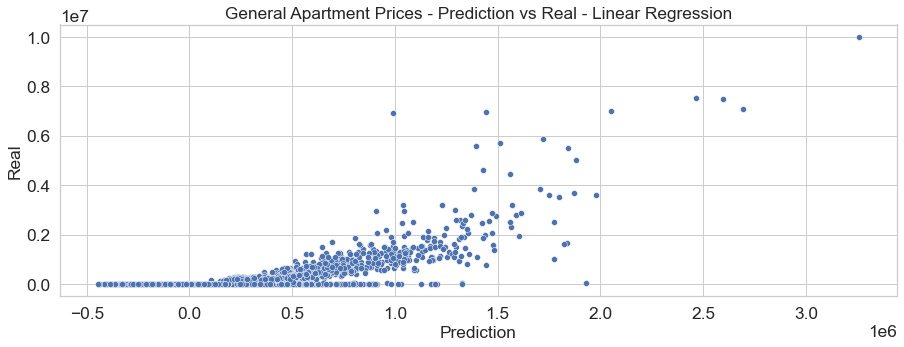

In [79]:
sns.scatterplot(x=y_test_pred, y=y_test)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('General Apartment Prices - Prediction vs Real - Linear Regression')

Text(0.5, 1.0, 'Apartment Sale Prices - Prediction vs Real - Linear Regression')

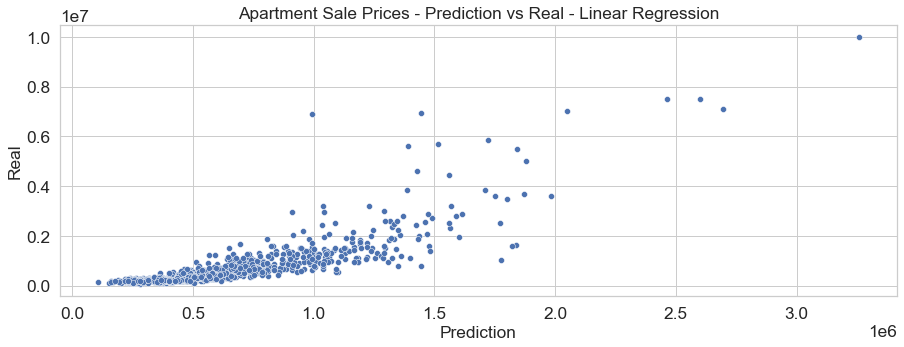

In [88]:
sns.scatterplot(x=y_test_pred[mask_test_sale], y=y_test[mask_test_sale])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Apartment Sale Prices - Prediction vs Real - Linear Regression')

Text(0.5, 1.0, 'Apartment Rent Prices - Prediction vs Real - Linear Regression')

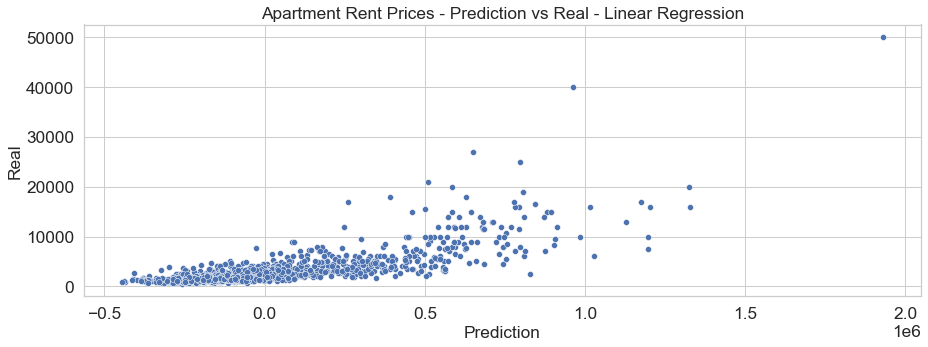

In [89]:
sns.scatterplot(x=y_test_pred[mask_test_rent], y=y_test[mask_test_rent])
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Apartment Rent Prices - Prediction vs Real - Linear Regression')

##### **Residual Analysis**
Plot of Prediction vs Residual. This analysis is interesting because we can detect if we meet the assumption of **homoscedasticity**.

<img src='./imgs/residual-analysis.png' width=600/>

In [81]:
residual_lin_reg = y_test - y_test_pred
# residual_sale_lin_reg = y_train_sale - y_train_pred_sale_lin_reg
# residual_rent_lin_reg = y_train_rent - y_train_pred_rent_lin_reg

Text(0.5, 1.0, 'General Apartment Price - Prediction vs Residual - Linear Regression')

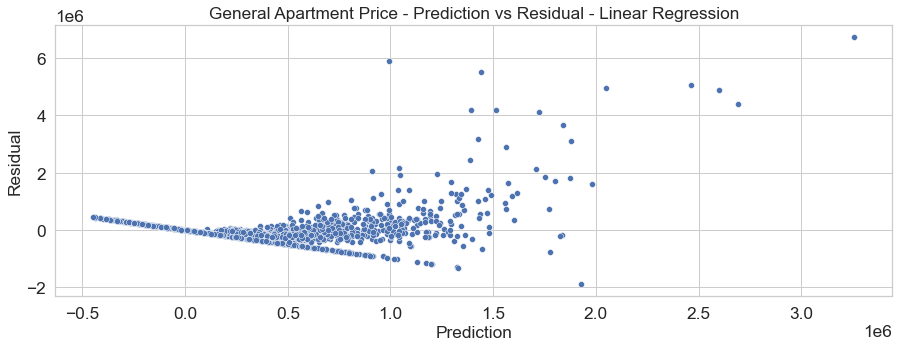

In [82]:
sns.scatterplot(x=y_test_pred, y=residual_lin_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('General Apartment Price - Prediction vs Residual - Linear Regression')

Text(0.5, 1.0, 'Apartment Sales Price - Prediction vs Residual - Linear Regression')

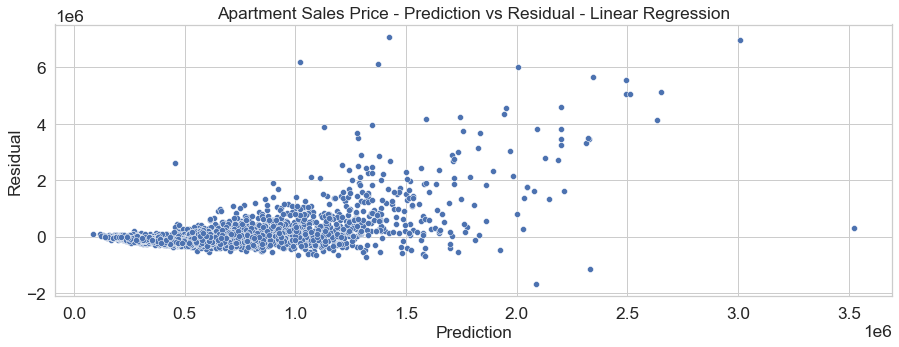

In [45]:
sns.scatterplot(x=y_train_pred_sale_lin_reg, y=residual_sale_lin_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Apartment Sales Price - Prediction vs Residual - Linear Regression')

Text(0.5, 1.0, 'Apartment Rent Price - Prediction vs Residual - Linear Regression')

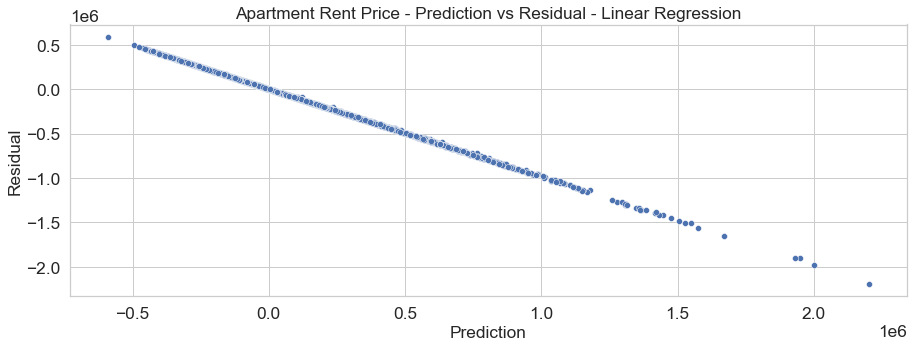

In [46]:
sns.scatterplot(x=y_train_pred_rent_lin_reg, y=residual_rent_lin_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Apartment Rent Price - Prediction vs Residual - Linear Regression')

#### **→ Decision Tree**

##### **Prediction**

In [48]:
y_train_pred_tree_reg = tree_reg.predict(X_train)

y_train_pred_sale_tree_reg = y_train_pred_tree_reg[mask_train_sale]
y_train_pred_rent_tree_reg = y_train_pred_tree_reg[mask_train_rent]

##### **Evaluation**

In [53]:
from sklearn.metrics import r2_score

tree_reg_r2 = r2_score(y_train, y_train_pred_tree_reg)
print(f'R² General decision tree regression = {tree_reg_r2}')

tree_reg_r2_score_sale = r2_score(y_train_sale, y_train_pred_sale_tree_reg)
print(f'R² Sale decision tree regression = {tree_reg_r2_score_sale}')

tree_reg_r2_score_rent = r2_score(y_train_rent, y_train_pred_rent_tree_reg)
print(f'R² Rent decision tree regression = {tree_reg_r2_score_rent}')

R² General decision tree regression = 0.9998857796450301
R² Sale decision tree regression = 0.9998435093106487
R² Rent decision tree regression = 0.9998937586568348


In [55]:
from sklearn.metrics import mean_squared_error

tree_reg_rmse = mean_squared_error(y_train, y_train_pred_tree_reg, squared=False)
print(f'RMSE general = {tree_reg_rmse}')

tree_reg_rmse_sale = mean_squared_error(y_train_sale, y_train_pred_sale_tree_reg, squared=False)
print(f'RMSE sale = {tree_reg_rmse_sale}')

tree_reg_rmse_rent = mean_squared_error(y_train_rent, y_train_pred_rent_tree_reg, squared=False)
print(f'RMSE rent = {tree_reg_rmse_rent}')

RMSE general = 6228.421898228392
RMSE sale = 9078.948871948269
RMSE rent = 37.15089306334221


#### **Visual Analysis**

Text(0.5, 1.0, 'Median housing value - Prediction vs Real - Decision Tree Regression')

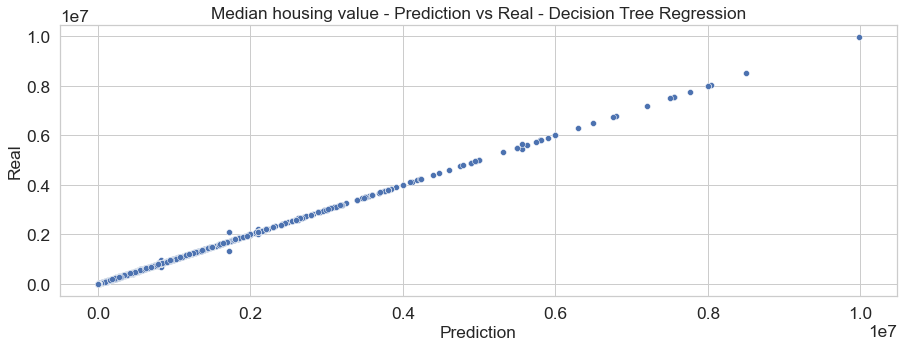

In [56]:
sns.scatterplot(x=y_train_pred_tree_reg, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('General Apartment Prices - Prediction vs Real - Decision Tree Regression')

Text(0.5, 1.0, 'Apartment Sale Prices - Prediction vs Real - Decision Tree Regression')

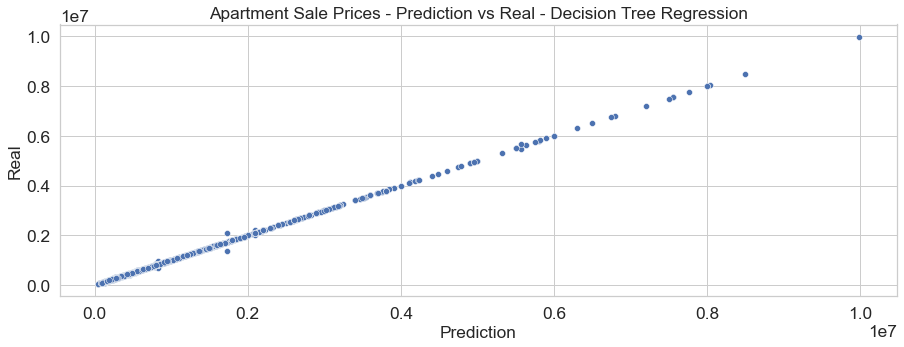

In [57]:
sns.scatterplot(x=y_train_pred_sale_tree_reg, y=y_train_sale)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Apartment Sale Prices - Prediction vs Real - Decision Tree Regression')

Text(0.5, 1.0, 'Apartment Rent Prices - Prediction vs Real - Decision Tree Regression')

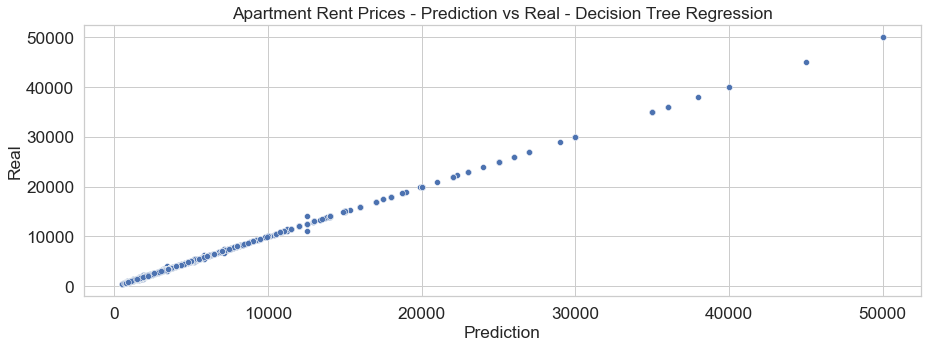

In [58]:
sns.scatterplot(x=y_train_pred_rent_tree_reg, y=y_train_rent)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Apartment Rent Prices - Prediction vs Real - Decision Tree Regression')

Text(0.5, 1.0, 'General Apartment Prices - Prediction vs Residual |')

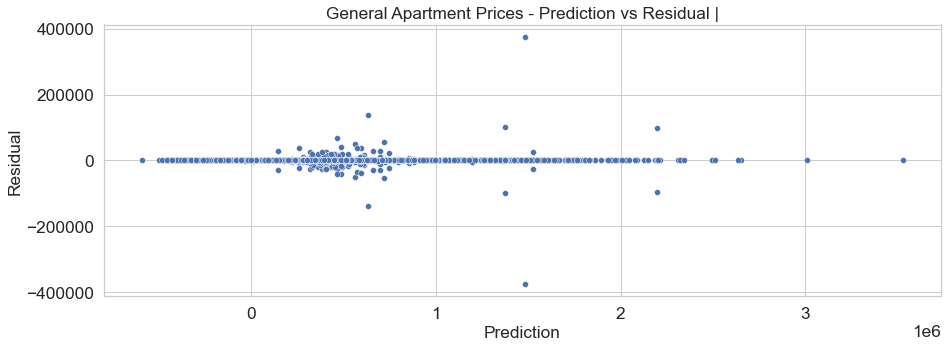

In [59]:
residual_tree_reg = y_train - y_train_pred_tree_reg

sns.scatterplot(x=y_train_pred_lin_reg, y=residual_tree_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('General Apartment Prices - Prediction vs Residual |')

Text(0.5, 1.0, 'Apartment Sale Prices - Prediction vs Residual |')

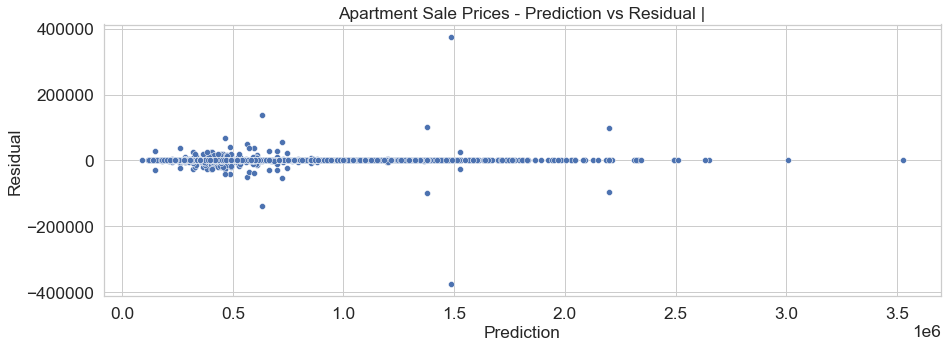

In [60]:
residual_tree_reg_sale = y_train_sale - y_train_pred_sale_tree_reg

sns.scatterplot(x=y_train_pred_sale_lin_reg, y=residual_tree_reg_sale)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Apartment Sale Prices - Prediction vs Residual |')

Text(0.5, 1.0, 'Apartment Rent Prices - Prediction vs Residual |')

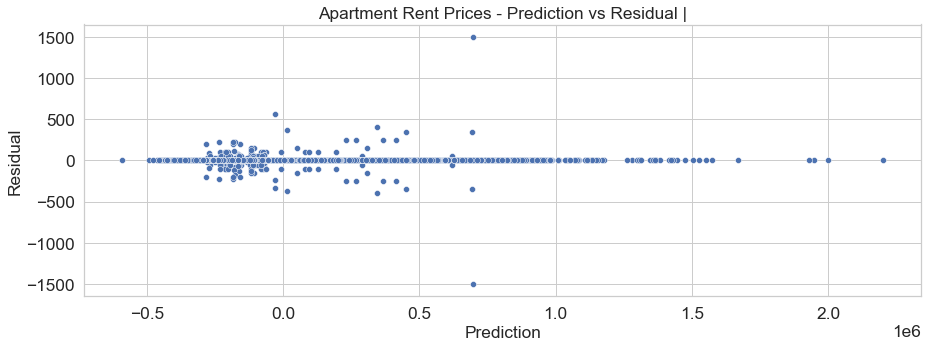

In [61]:
residual_tree_reg_rent = y_train_rent - y_train_pred_rent_tree_reg

sns.scatterplot(x=y_train_pred_rent_lin_reg, y=residual_tree_reg_rent)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Apartment Rent Prices - Prediction vs Residual |')

<h3 style="color: #ff5757 !important"><b>Cross-validation</b></h3>

#### **→ Decision Tree**

The following code ***randomly splits*** (_no stratification_) the _training set_ into **10 folds**, then it trains and evaluates the Decision Tree model 10 times, picking a different fold (**validation set**) for evaluation every time and training on the other 9 folds (**train-dev set**). <br/>
The result is an _array_ containing the 10 evaluation scores.

In [65]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=27)
tree_neg_mse_scores = cross_val_score(tree_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

tree_rmse_scores = np.sqrt(-tree_neg_mse_scores)

In [63]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [66]:
display_scores(tree_rmse_scores)

Scores: [181515.4624081  226937.61722755 181302.69455587 181709.59037405
 227616.62133283 208693.9806532  213021.61186189 286713.33752813
 158063.75611877 260115.72771011]
Mean: 212569.03997705193
Standard deviation: 37511.61370930972


In [68]:
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_neg_mse_scores = cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

lin_rmse_scores = np.sqrt(-lin_neg_mse_scores)

In [69]:
display_scores(lin_rmse_scores)

Scores: [391222.92381511 394974.21545283 421531.92965134 371247.19239913
 308114.49819565 486586.16872947 466501.83177041 384139.08786562
 307543.52637238 493899.61561616]
Mean: 402576.0989868092
Standard deviation: 62694.33005015158


In [90]:
np.random.seed(27)

y_test_pred_baseline = []

for true_housing_price in y_test:
    error_rate = 1 + np.random.randint(20, 26) / 100
    y_test_pred_baseline.append(true_housing_price * error_rate)

In [91]:
baseline_rmse_test = mean_squared_error(y_test, y_test_pred_baseline, squared=False)
print(f'RMSE Baseline in the Test Set: {baseline_rmse_test}')

RMSE Baseline in the Test Set: 158910.2794440401
